# ==============================================
# Previsão de Temperatura e Chuva (NOAA)
# Modelos: SARIMAX (temperatura) + Regressão Logística (chuva)
# ==============================================

In [1]:
# 1. Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [5]:
# ==============================================
# 2. Carregamento do dataset NOAA
# (Supondo que já baixou um CSV via Kaggle ou NOAA API)
# Exemplo: daily/hourly weather data com colunas:
# date, temperature, precipitation, humidity, pressure
# ==============================================
import os
file_path = '/home/nicholas/projects/IOT/data/raw/weather_data.csv'
df = pd.read_csv(file_path, parse_dates=['datetime'], index_col='datetime')

# Exibir primeiras linhas
print(df.head())

                                  location  temperature  humidity  pressure  \
datetime                                                                      
2024-07-15 09:16:21.854406        Salvador         23.7      71.4    1017.2   
2024-07-15 10:16:21.854406       Fortaleza         28.3      48.6    1004.6   
2024-07-15 11:16:21.854406        Salvador         29.7      69.1    1014.8   
2024-07-15 12:16:21.854406  Rio de Janeiro         23.7      62.1    1040.8   
2024-07-15 13:16:21.854406        Salvador         23.4      48.7     993.1   

                            wind_speed wind_direction  precipitation  \
datetime                                                               
2024-07-15 09:16:21.854406        11.9             SW           2.56   
2024-07-15 10:16:21.854406         6.7             NW           0.19   
2024-07-15 11:16:21.854406         0.5              W           5.70   
2024-07-15 12:16:21.854406         0.0             SW           0.00   
2024-07-15 13:

In [6]:
# ==============================================
# 3. Pré-processamento
# ==============================================
# Garantir ordenação temporal
df = df.sort_index()

# Tratar valores faltantes
numeric_cols = ['temperature', 'precipitation', 'humidity', 'pressure']
df[numeric_cols] = df[numeric_cols].interpolate()

# Criar variável binária para chuva
df['rain_flag'] = (df['precipitation'] > 0).astype(int)

# Verificar dados
print(df.describe())


        temperature      humidity      pressure   wind_speed  precipitation  \
count  10000.000000  10000.000000  10000.000000  10000.00000   10000.000000   
mean      24.646380     67.778310   1013.094490      8.14578       0.818329   
std        4.510959     10.288457     15.173688      8.12046       1.589072   
min       11.600000     29.000000    955.500000      0.00000       0.000000   
25%       21.200000     60.900000   1002.900000      2.40000       0.000000   
50%       24.500000     67.900000   1012.900000      5.90000       0.000000   
75%       27.900000     74.700000   1023.300000     11.40000       1.010000   
max       38.500000    100.000000   1066.300000     50.00000      16.900000   

         visibility          hour         month   day_of_week    feels_like  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       6.597330     11.505600      6.678600      2.988400     28.031070   
std        1.136507      6.922164      3.259043    

/home/nicholas/projects/IOT/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/nicholas/projects/IOT/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/nicholas/projects/IOT/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Previsão Temperatura (próximas 6h):
2025-06-13 17:16:21.854406    23.717334
2025-06-13 18:16:21.854406    23.652817
2025-06-13 19:16:21.854406    23.769945
2025-06-13 20:16:21.854406    24.256004
2025-06-13 21:16:21.854406    24.486276
2025-06-13 22:16:21.854406    24.887149
Freq: h, Name: predicted_mean, dtype: float64


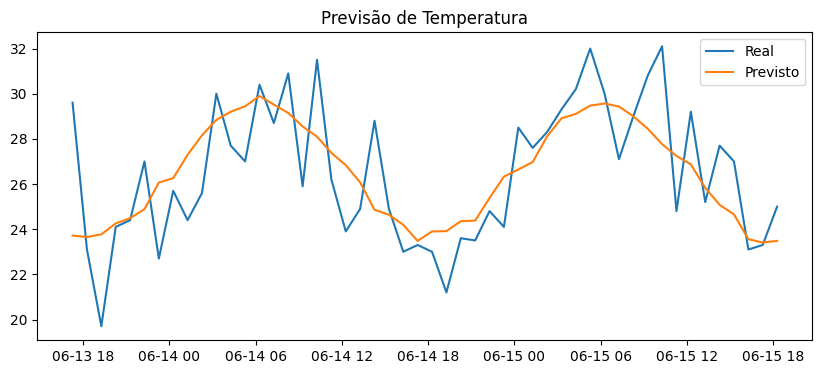

In [7]:
# ==============================================
# 4. Modelo 1: Previsão de Temperatura (SARIMAX)
# ==============================================
# Variáveis
y = df['temperature']
exog = df[['humidity', 'pressure']]

# Split treino/teste
train_size = int(len(df)*0.8)
y_train, y_test = y[:train_size], y[train_size:]
exog_train, exog_test = exog[:train_size], exog[train_size:]

# Ajustar SARIMAX (ordens escolhidas de forma simples, depois ajustar com auto_arima)
model = SARIMAX(y_train, exog=exog_train, order=(3,1,2), seasonal_order=(1,1,1,24))
results = model.fit(disp=False)

# Previsão para as próximas 6 horas
forecast = results.get_forecast(steps=6, exog=exog_test[:6])
forecast_values = forecast.predicted_mean
print("Previsão Temperatura (próximas 6h):")
print(forecast_values)

# Plot previsão vs real
plt.figure(figsize=(10,4))
plt.plot(y_test[:50], label='Real')
plt.plot(results.get_forecast(steps=50, exog=exog_test[:50]).predicted_mean, label='Previsto')
plt.title('Previsão de Temperatura')
plt.legend()
plt.show()

In [14]:
# ==============================================
# 5. Modelo 2: Previsão de Chuva (Regressão Logística)
# ==============================================
# Criar lags
for lag in range(1, 7):
    df[f'temp_lag_{lag}'] = df['temperature'].shift(lag)
    df[f'humidity_lag_{lag}'] = df['humidity'].shift(lag)

df.dropna(inplace=True)

# Features e target
X = df.drop(['precipitation','rain_flag','air_quality','is_weekend','will_rain'], axis=1)
y = df['rain_flag']

X = pd.get_dummies(X, columns=['location'])
X = pd.get_dummies(X, columns=['wind_direction'])
X = pd.get_dummies(X, columns=['season'])

# Split
t_train_size = int(len(X)*0.8)
X_train, X_test = X[:t_train_size], X[t_train_size:]
y_train, y_test = y[:t_train_size], y[t_train_size:]

# Treinar modelo
model_rain = LogisticRegression(max_iter=1000)
model_rain.fit(X_train, y_train)

# Previsões
preds = model_rain.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, preds))
print("Relatório de Classificação:")
print(classification_report(y_test, preds))


Accuracy: 0.831409934771701
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1171
           1       0.79      0.80      0.80       822

    accuracy                           0.83      1993
   macro avg       0.83      0.83      0.83      1993
weighted avg       0.83      0.83      0.83      1993



/home/nicholas/projects/IOT/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


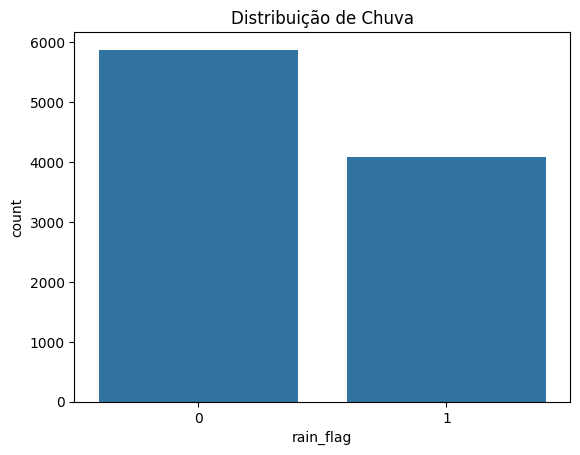

In [15]:
# ==============================================
# 6. Visualização da distribuição da chuva
sns.countplot(x=y)
plt.title('Distribuição de Chuva')
plt.show()

# ==============================================
# Próximos passos:
# - Usar auto_arima para encontrar melhores parâmetros
# - Implementar cross-validation
# - Avaliar métricas para regressão (RMSE) e classificação (F1-score)
# - Expandir para previsão contínua com janelas deslizantes